# Analysis of Fake News in datasets spanish_fake_news_1.csv and spanish_fake_news_2.csv

Data From: https://github.com/jpposadas/FakeNewsCorpusSpanish/

(spanish_fake_news_1.csv from train.csv; spanish_fake_news_2.csv from test.csv: manually created union to repartition)

Features (1 and 2 are inconsistent and adapted together in data scrubbing below):
- `Topic`: News Subject
- `Headline`
- `Text`

Labels:
- `Category`: Boolean representing if real

Formatted using Black

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from lib import (
    pd,
    train_test_split,
    grs,
    highest_freq_words,
    grid_search_report,
)
from NLP_algorithms import (
    get_textvec_pipeline,
    get_textvect_grid_search_params
)
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from joblib import parallel_backend
from IPython.display import display  # (For linter)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package averaged_per

# Data Wrangling 
### (Combining two datasets into one dataframe; ensuring consistent nomenclature)

In [ ]:
# Merge two Spanish fake news datasets into one dataframe

spanish_fake_news_1 = pd.read_csv("data/spanish_fake_news_1.csv")
spanish_fake_news_2 = pd.read_csv("data/spanish_fake_news_2.csv")

# Change all of the values in CATEGORY of fake_news_2 from 'FALSE' to
# 'Fake' and 'TRUE' to 'True'
spanish_fake_news_2["CATEGORY"] = spanish_fake_news_2["CATEGORY"].replace(
    {False: "Fake", True: "True"}
)

# Rename the columns of fake_news_2 to match those of fake_news_1
spanish_fake_news_2.rename(
    columns={
        "CATEGORY": "Category",
        "TITLE": "Title",
        "TEXT": "Text",
        "ID": "Id",
        "HEADLINE": "Headline",
        "LINK": "Link",
        "SOURCE": "Source",
        "TOPICS": "Topic",
    },
    inplace=True,
)

# Concatenate the two dataframes into one
spanish_fake_news = pd.concat(
    [spanish_fake_news_1, spanish_fake_news_2], ignore_index=True
)
# display(spanish_fake_news.tail())

# Map FAKE->1 and TRUE->0
spanish_fake_news["Category"] = spanish_fake_news["Category"].replace(
    {"Fake": 1, "True": 0}
)

df = spanish_fake_news

# View first and last 5 rows
display(spanish_fake_news.head())
display(spanish_fake_news.tail())

/var/folders/tp/3nd20r2x6ns2txnn5kmx15dr0000gn/T/ipykernel_95476/598103754.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spanish_fake_news['Category'] = spanish_fake_news['Category'].replace({'Fake': 1, 'True': 0})


,Id,Category,Topic,Source,Headline,Text,Link
0,1,1,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,1,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,1,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,0,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,1,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...


,Id,Category,Topic,Source,Headline,Text,Link
1243,568,0,Covid-19,El Financiero,Encuentran nueva variante de COVID en México: ...,El Instituto de Diagnóstico y Referencia Epide...,https://www.elfinanciero.com.mx/salud/encuentr...
1244,569,1,Sociedad,diariogol,El móvil de más de 60.000 euros de la princesa...,La hija del rey Felipe y de la reina Letizia y...,https://www.diariogol.com/gossip/el-movil-de-m...
1245,570,1,Política,AFPFactual,NaN,"Evidentemente, Barak Obama ha sido arrestado e...","Perma | Obama, Biden y la directora de la CIA,..."
1246,571,0,Covid-19,Redacción Médica,Covid: las vacunas puestas en España no alcanz...,El Ministerio de Sanidad ha actualizado los da...,https://www.redaccionmedica.com/secciones/sani...
1247,572,1,Covid-19,El Sol de la Laguna,En 2014 una revista ya alertaba sobre el coron...,Fue en el mes de febrero de 2014 cuando la rev...,https://www.Noticiadelsoldelalaguna.com.mx/dob...


## Data Selection & Holdout

In [ ]:
X = df[["Text", "Topic", "Source"]]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=grs
)

# Exploratory Data Analysis

<Axes: xlabel='Category', ylabel='count'>

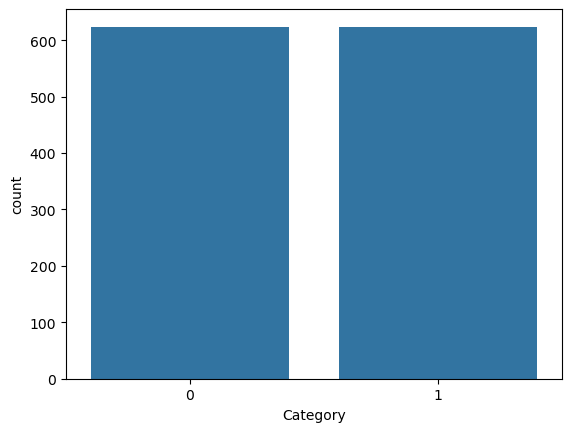

In [19]:
sns.countplot(data=df, x="Category")

In [1]:
highest_freq_words(df, 20, "Text")

NameError: name 'highest_freq_words' is not defined

# Model 1: Simple Bag of Words Sentiment Analysis

In [ ]:
estimator_sbw = get_textvec_pipeline(
    tf_idf=False,
    pca=False,
    text_column="Text",
    categorical_columns=["Topic", "Source"],
    target_column="Category",
)
grid_search_sbw = GridSearchCV(
    estimator_sbw,
    get_textvect_grid_search_params(tf_idf=False, pca=False),
    scoring="f1",
    cv=5,
    n_jobs=-1,
)

In [11]:
grid_search_sbw.fit(X_train, y_train)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milescaprio/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milescaprio/nltk_data...


In [ ]:
grid_search_report(
    "Bag of words sentiment anlysis, linear regression",
    "F1",
    grid_search_sbw,
    X_test,
    y_test,
)

Report for:  Bag of words sentiment anlysis, linear regression
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (250, 1)
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       134
           1       0.80      0.88      0.84       116

    accuracy                           0.84       250
   macro avg       0.84      0.85      0.84       250
weighted avg       0.85      0.84      0.84       250

Confusion Matrix:
[[109  25]
 [ 14 102]]
Best Parameters: {'process__countvect__countvect__min_df': 0.05, 'process__countvect__countvect__ngram_range': (1, 2)}
F1 Score of Best Model: 80.58 %


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


# Model 2: TF-IDF Sentiment Analysis

In [ ]:
estimator_tfidf = get_textvec_pipeline(
    tf_idf=True,
    pca=False,
    text_column="Text",
    categorical_columns=["Topic", "Source"],
    target_column="Category",
)
grid_search_tfidf = GridSearchCV(
    estimator_tfidf,
    get_textvect_grid_search_params(tf_idf=True, pca=False),
    scoring="f1",
    cv=5,
    n_jobs=-1,
)

In [ ]:
with parallel_backend("threading"):
    grid_search_tfidf.fit(X_train, y_train)

[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (798, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (799, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (200, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (199, 1)


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (998, 1)


In [ ]:
grid_search_report(
    "TF-IDF sentiment anlysis, linear regression",
    "F1",
    grid_search_tfidf,
    X_test,
    y_test,
)

[autoreload of lib failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/CSB320/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/milescaprio/Library/CloudStorage/OneDrive-SeattleColleges/CSB 320/projects/CSB320_P2/lib.py", line 19, in <module>
    with suppress_output():
NameError: name 'suppress_output' is not defined
]


Report for:  TF-IDF sentiment anlysis, linear regression
[DEBUG] type(X): <class 'pandas.core.frame.DataFrame'>, shape: (250, 1)
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       134
           1       0.75      0.89      0.81       116

    accuracy                           0.81       250
   macro avg       0.82      0.81      0.81       250
weighted avg       0.82      0.81      0.81       250

Confusion Matrix:
[[ 99  35]
 [ 13 103]]
Best Parameters: {'process__tfidf__tfidf__max_df': 0.9, 'process__tfidf__tfidf__min_df': 0.01, 'process__tfidf__tfidf__ngram_range': (1, 1)}
F1 Score of Best Model: 80.62 %


/opt/anaconda3/envs/CSB320/lib/python3.9/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
